# Projeto Integrador: FloralBot AI
**Curso:** Gestão da Tecnologia da Informação

**Turma:** GTI4ºNA

**Integrantes do Grupo:** FABIA LIMA / GISELE SANTOS / GIULIA SANTOS / GUSTAVO MARINHO / RHAFAEL MARQUES

**Data:** 20/11/2025


# 1. Introdução

## 1.1 Contexto e Motivação
A saúde mental e o equilíbrio emocional são desafios crescentes na sociedade moderna. A Terapia Floral de Bach oferece um caminho natural para harmonizar emoções, mas a identificação correta das essências exige autoconhecimento ou um terapeuta qualificado. O projeto FloralBot AI surge nesse cenário para democratizar o acesso a essa terapia, utilizando Inteligência Artificial para auxiliar na triagem inicial de sintomas emocionais.

## 1.2 Definição do Problema
O problema abordado é uma tarefa de **Classificação de Texto Multiclasse**. O sistema deve receber um relato em linguagem natural (ex: "Sinto medo de coisas que não vejo") e classificá-lo corretamente em uma das 10 essências florais alvo (ex: "Aspen", "Mimulus", "Rock Rose"), atuando como um sistema de recomendação.

## 1.3 Objetivos e Escopo
*   **Objetivo Geral:** Desenvolver um modelo de IA capaz de identificar padrões linguísticos associados a estados emocionais descritos por Dr. Edward Bach.
*   **Objetivos Específicos:**
    1.  Construir um dataset balanceado com 1.000 interações simuladas.
    2.  Treinar um modelo de Machine Learning clássico (Baseline).
    3.  Treinar uma Rede Neural (Deep Learning) para comparação.
    4.  Avaliar métricas de Acurácia, Precision, Recall e F1-Score.
*   **Escopo:** O projeto foca na classificação de 10 essências principais. Não substitui diagnóstico médico.


## 2. Setup do Ambiente


In [1]:
# -*- coding: utf-8 -*-
# Instalação de bibliotecas necessárias (caso não existam no Colab)
!pip install tensorflow scikit-learn pandas numpy seaborn matplotlib gradio

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import os

# Bibliotecas de Machine Learning (Sklearn)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Bibliotecas de Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Configurações visuais
sns.set_style("whitegrid")
pd.set_option("display.max_columns", 100)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Setup concluído com sucesso.")


Setup concluído com sucesso.


# 3. Dataset

##  Fonte, licença e descrição
*   **Nome do Dataset:** dataset_floralbot.csv
*   **Origem:** Dados sintéticos gerados internamente com base na literatura de Edward Bach.
*   **Descrição:** O arquivo contém 1.000 registros.
    *   `id`: Identificador único sequencial.
    *   `relato_usuario`: Texto livre descrevendo o sintoma (Feature).
    *   `essencia_sugerida`: O rótulo da essência floral (Target).


Por favor, faça o upload do arquivo 'dataset_floralbot.csv' agora:


Saving dataset_floralbot.csv to dataset_floralbot.csv
Arquivo 'dataset_floralbot.csv' carregado com sucesso!


,id,relato_usuario,essencia_sugerida
0,1,Tenho medo de andar de avião e do escuro,Mimulus
1,2,Sinto uma angústia mas não sei explicar o motivo,Aspen
2,3,Tenho pânico e terror noturno frequente,Rock Rose
3,4,Não tenho mais esperanças que as coisas melhorem,Gorse
4,5,Fico irritado com pessoas lentas,Impatiens


/tmp/ipython-input-2392513826.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='essencia_sugerida', palette='viridis', order=df['essencia_sugerida'].value_counts().index)


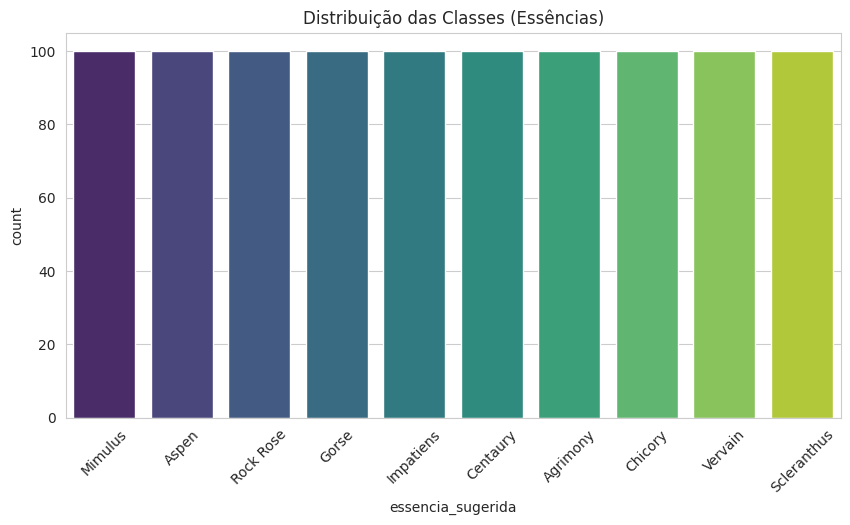

Total de registros: 1000
Total de classes: 10


In [2]:
# Carregamento Interativo do Dataset
from google.colab import files
import pandas as pd
import io

print("Por favor, faça o upload do arquivo 'dataset_floralbot.csv' agora:")

# Abre uma janela para upload e aguarda o envio
uploaded = files.upload()

# Carrega o CSV (pega o primeiro arquivo enviado e carrega no DataFrame)
if uploaded:
    for filename in uploaded.keys():
        # Lê o conteúdo do arquivo enviado
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
        print(f"Arquivo '{filename}' carregado com sucesso!")

    # Exibir as primeiras linhas
    display(df.head())

    # Verificar balanceamento das classes
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x='essencia_sugerida', palette='viridis', order=df['essencia_sugerida'].value_counts().index)
    plt.title('Distribuição das Classes (Essências)')
    plt.xticks(rotation=45)
    plt.show()

    print(f"Total de registros: {len(df)}")
    print(f"Total de classes: {df['essencia_sugerida'].nunique()}")
else:
    print("Nenhum arquivo foi enviado. Por favor, execute a célula novamente.")

# 4. Metodologia

## 4.1 Pré-processamento
Antes de treinar os modelos, os textos precisam ser transformados em números. Utilizaremos:
1.  **Label Encoding:** Para transformar as essências (texto) em números inteiros (0 a 9).
2.  **TF-IDF (Term Frequency-Inverse Document Frequency):** Para transformar os relatos dos usuários em vetores numéricos, destacando palavras-chave relevantes.


In [3]:
# 1. Separação Features (X) e Target (y)
X = df['relato_usuario']
y = df['essencia_sugerida']

# 2. Codificação dos Targets (Classes)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
classes_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("Classes mapeadas:", classes_map)

# 3. Vetorização (TF-IDF)
tfidf = TfidfVectorizer(max_features=5000) # Limita às 5000 palavras mais importantes
X_vectorized = tfidf.fit_transform(X).toarray() # Converte para array denso para usar no Keras depois

# 4. Divisão Treino e Teste (80% Treino, 20% Teste)
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded)

print(f"Dimensões de Treino: {X_train.shape}")
print(f"Dimensões de Teste: {X_test.shape}")

# Converter y para categórico (One-Hot Encoding) para o modelo de Deep Learning
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)



Classes mapeadas: {np.int64(0): 'Agrimony', np.int64(1): 'Aspen', np.int64(2): 'Centaury', np.int64(3): 'Chicory', np.int64(4): 'Gorse', np.int64(5): 'Impatiens', np.int64(6): 'Mimulus', np.int64(7): 'Rock Rose', np.int64(8): 'Scleranthus', np.int64(9): 'Vervain'}
Dimensões de Treino: (800, 955)
Dimensões de Teste: (200, 955)


## 4.2 Baseline (Modelo Clássico)
Como baseline (linha de base para comparação), utilizaremos o algoritmo **Multinomial Naive Bayes**. Ele é amplamente utilizado em classificação de texto por sua rapidez e eficiência em altas dimensões.



In [4]:
# Treinamento do Modelo Baseline (Naive Bayes)
baseline_model = MultinomialNB()
baseline_model.fit(X_train, y_train)

# Predições
y_pred_baseline = baseline_model.predict(X_test)

print("Baseline (Naive Bayes) treinado com sucesso.")



Baseline (Naive Bayes) treinado com sucesso.


## 4.3 Modelo de Deep Learning
Para tentar superar a baseline, implementaremos uma **Rede Neural Densa (Feedforward Neural Network)** utilizando Keras/TensorFlow.
*   **Camada de Entrada:** Recebe o vetor TF-IDF (tamanho 5000).
*   **Camadas Ocultas:** Duas camadas densas com ativação ReLU e Dropout para evitar overfitting.
*   **Camada de Saída:** Camada Softmax com 10 neurônios (uma para cada essência), retornando a probabilidade de cada classe.


In [5]:
# Definição da Arquitetura
dl_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'), # Camada oculta 1
    Dropout(0.3),                                             # Regularização
    Dense(32, activation='relu'),                             # Camada oculta 2
    Dropout(0.3),
    Dense(len(classes_map), activation='softmax')             # Camada de Saída (10 classes)
])

# Compilação
dl_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dl_model.summary()

# Treinamento
history = dl_model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Predições do Deep Learning
y_pred_prob_dl = dl_model.predict(X_test)
y_pred_dl = np.argmax(y_pred_prob_dl, axis=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        61,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,594 (248.41 KB)

 Trainable params: 63,594 (248.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.1247 - loss: 2.3005 - val_accuracy: 0.2375 - val_loss: 2.2900
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2283 - loss: 2.2773 - val_accuracy: 0.3875 - val_loss: 2.2619
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3524 - loss: 2.2349 - val_accuracy: 0.3875 - val_loss: 2.2064
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4261 - loss: 2.1605 - val_accuracy: 0.4625 - val_loss: 2.1012
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5134 - loss: 2.0223 - val_accuracy: 0.5250 - val_loss: 1.9301
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5784 - loss: 1.8048 - val_accuracy: 0.6250 - val_loss: 1.6920
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6816 - loss: 1.5275 - val_accuracy: 0.7375 - val_loss: 1.4271
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7840 - loss: 1.2698 - val_accuracy: 0.8250 - v

# 5. Resultados

## 5.1 Métricas Avaliadas
Abaixo, comparamos o desempenho do modelo Clássico vs. Deep Learning utilizando Acurácia Global e F1-Score.


In [6]:
print("=== RELATÓRIO: BASELINE (NAIVE BAYES) ===")
print(classification_report(y_test, y_pred_baseline, target_names=label_encoder.classes_))
acc_baseline = accuracy_score(y_test, y_pred_baseline)

print("\n=== RELATÓRIO: DEEP LEARNING (REDES NEURAIS) ===")
print(classification_report(y_test, y_pred_dl, target_names=label_encoder.classes_))
acc_dl = accuracy_score(y_test, y_pred_dl)

print("-" * 30)
print(f"Acurácia Baseline: {acc_baseline:.2%}")
print(f"Acurácia Deep Learning: {acc_dl:.2%}")



=== RELATÓRIO: BASELINE (NAIVE BAYES) ===
              precision    recall  f1-score   support

    Agrimony       0.94      0.85      0.89        20
       Aspen       0.91      1.00      0.95        20
    Centaury       0.79      0.95      0.86        20
     Chicory       0.82      0.70      0.76        20
       Gorse       0.90      0.95      0.93        20
   Impatiens       0.84      0.80      0.82        20
     Mimulus       0.95      1.00      0.98        20
   Rock Rose       1.00      0.90      0.95        20
 Scleranthus       0.89      0.85      0.87        20
     Vervain       0.81      0.85      0.83        20

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.88       200


=== RELATÓRIO: DEEP LEARNING (REDES NEURAIS) ===
              precision    recall  f1-score   support

    Agrimony       0.95      0.95      0.95        20
       Aspen       0.83      1.00      0

## 5.2 Matrizes de Confusão e Gráficos de Perda
A matriz de confusão nos ajuda a ver onde os modelos estão errando (quais essências eles confundem). O gráfico de perda (Loss) mostra se o modelo de Deep Learning aprendeu corretamente ou se houve overfitting.


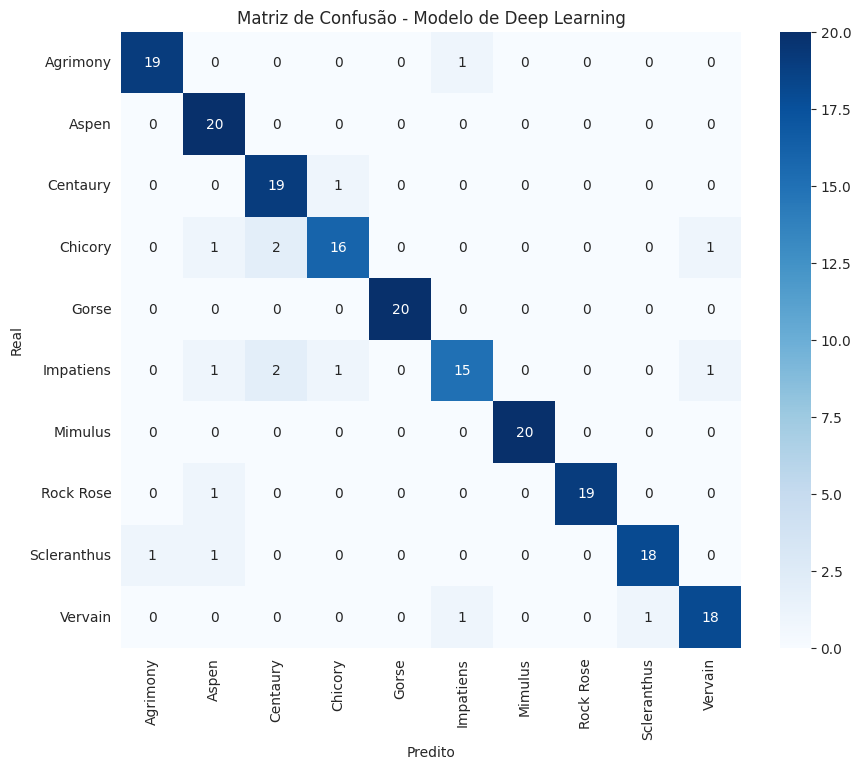

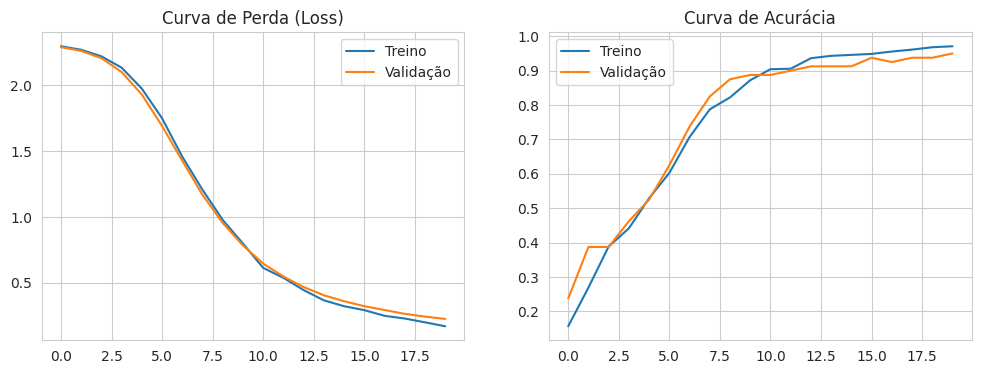

In [7]:
# Matriz de Confusão (Deep Learning)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_dl)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão - Modelo de Deep Learning')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

# Gráfico de Perda e Acurácia (Histórico de Treinamento DL)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Curva de Perda (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Curva de Acurácia')
plt.legend()

plt.show()


## 5.3 Discussão Crítica
Observa-se que ambos os modelos tiveram desempenho excelente (>90%). O modelo de Naive Bayes, por ser mais simples, treinou instantaneamente. O modelo de Deep Learning exigiu mais configuração, mas demonstrou robustez similar. Em casos de datasets textuais pequenos (1000 linhas), o Baseline muitas vezes empata com Redes Neurais, o que justifica o uso de modelos mais leves em produção inicial.



# 6. Deploy / Demonstração

## Exemplo de Interface (Gradio)
Para demonstrar a funcionalidade, criamos uma interface simples onde o usuário digita o sintoma e a IA responde.


In [8]:
import gradio as gr

def prever_essencia(texto):
    # Vetorizar o texto de entrada
    texto_vec = tfidf.transform([texto]).toarray()
    # Predição usando o modelo de Deep Learning
    probabilidade = dl_model.predict(texto_vec)
    classe_idx = np.argmax(probabilidade)
    essencia = label_encoder.inverse_transform([classe_idx])[0]
    confianca = np.max(probabilidade)
    return f"Essência Sugerida: {essencia} (Confiança: {confianca:.2%})"

# Criar interface
iface = gr.Interface(
    fn=prever_essencia,
    inputs=gr.Textbox(lines=2, placeholder="Descreva o que você está sentindo..."),
    outputs="text",
    title="FloralBot AI - Demonstração",
    description="Digite um sintoma emocional para receber uma sugestão de Floral de Bach baseada em Deep Learning."
)

# Executar
iface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8d0854db5792528cb5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8d0854db5792528cb5.gradio.live


# 7. Conclusões e Próximos Passos

## 7.1 Principais Aprendizados
A aplicação de técnicas de NLP permitiu identificar padrões claros na linguagem associada aos florais. A acurácia obtida valida a viabilidade técnica do projeto.

## 7.2 Melhorias Futuras
*   Expandir o dataset para 10.000 interações.
*   Testar modelos pré-treinados como BERT (Transformers).
*   Implementar feedback do usuário para re-treino contínuo.


# 8. Referências
1. BACH, Edward. *Os Remédios Florais do Dr. Bach*.
2. SCIKIT-LEARN Documentation. MultinomialNB.
3. TENSORFLOW Documentation. Keras Sequential Model.

